<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:16] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


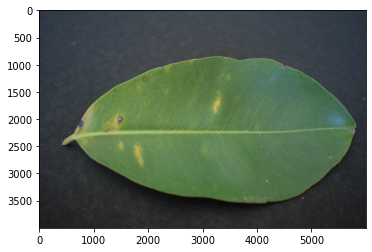

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

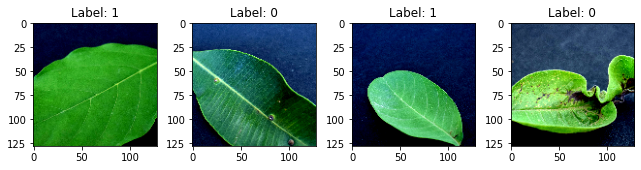

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.259109684250247 samples/sec                   batch loss = 1.3287136554718018 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2615532297249306 samples/sec                   batch loss = 0.4634990394115448 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2721730569848393 samples/sec                   batch loss = 1.1115309000015259 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2615982906792722 samples/sec                   batch loss = 0.7987958788871765 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2671453464295428 samples/sec                   batch loss = 0.7817211151123047 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2640458953431393 samples/sec                   batch loss = 0.9246730208396912 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2659518862983543 samples/sec                   batch loss = 1.1843154430389404 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2670590267296393 samples/sec                   batch loss = 1.1283916234970093 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2707792108439238 samples/sec                   batch loss = 1.1343960762023926 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2701835795548881 samples/sec                   batch loss = 0.22469134628772736 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2708977109818709 samples/sec                   batch loss = 0.704558253288269 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2644590733021839 samples/sec                   batch loss = 0.3954388201236725 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2628567428395507 samples/sec                   batch loss = 0.4952965974807739 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2492650414541118 samples/sec                   batch loss = 0.6871930956840515 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.264669052498656 samples/sec                   batch loss = 0.3422601819038391 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.262897524001481 samples/sec                   batch loss = 0.46412837505340576 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.2660950936333828 samples/sec                   batch loss = 0.44968846440315247 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.266301697910814 samples/sec                   batch loss = 0.43023163080215454 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2690042608706964 samples/sec                   batch loss = 0.2962821424007416 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.2760242040657166 samples/sec                   batch loss = 0.7356197834014893 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2669770243392087 samples/sec                   batch loss = 0.299416184425354 | accuracy = 0.6476190476190476


Epoch[1] Batch[110] Speed: 1.2660992976737186 samples/sec                   batch loss = 0.6772592067718506 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.2679705703413433 samples/sec                   batch loss = 0.3465330898761749 | accuracy = 0.6608695652173913


Epoch[1] Batch[120] Speed: 1.2712689490665459 samples/sec                   batch loss = 1.4011788368225098 | accuracy = 0.6645833333333333


Epoch[1] Batch[125] Speed: 1.2716239225026558 samples/sec                   batch loss = 0.44567346572875977 | accuracy = 0.67


Epoch[1] Batch[130] Speed: 1.2704163393867838 samples/sec                   batch loss = 0.7201169729232788 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.274665198608394 samples/sec                   batch loss = 0.8615521788597107 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2736940135481887 samples/sec                   batch loss = 1.1436102390289307 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2705241880397027 samples/sec                   batch loss = 0.42531657218933105 | accuracy = 0.6655172413793103


Epoch[1] Batch[150] Speed: 1.2719802514662801 samples/sec                   batch loss = 0.3465794324874878 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2640008498388282 samples/sec                   batch loss = 0.6719844937324524 | accuracy = 0.6661290322580645


Epoch[1] Batch[160] Speed: 1.267989832329266 samples/sec                   batch loss = 1.166778802871704 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2648347593859453 samples/sec                   batch loss = 0.7985385656356812 | accuracy = 0.6681818181818182


Epoch[1] Batch[170] Speed: 1.271731108702995 samples/sec                   batch loss = 1.2175240516662598 | accuracy = 0.6647058823529411


Epoch[1] Batch[175] Speed: 1.2686502686196435 samples/sec                   batch loss = 1.5273568630218506 | accuracy = 0.6685714285714286


Epoch[1] Batch[180] Speed: 1.271265384920518 samples/sec                   batch loss = 0.6686082482337952 | accuracy = 0.6680555555555555


Epoch[1] Batch[185] Speed: 1.2692331319068557 samples/sec                   batch loss = 0.32319629192352295 | accuracy = 0.668918918918919


Epoch[1] Batch[190] Speed: 1.2711097379298975 samples/sec                   batch loss = 0.30674493312835693 | accuracy = 0.6710526315789473


Epoch[1] Batch[195] Speed: 1.2719859412373868 samples/sec                   batch loss = 0.7709783315658569 | accuracy = 0.6692307692307692


Epoch[1] Batch[200] Speed: 1.2737364646839342 samples/sec                   batch loss = 0.262495756149292 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.269355761633537 samples/sec                   batch loss = 0.8357996940612793 | accuracy = 0.6707317073170732


Epoch[1] Batch[210] Speed: 1.2761765916003758 samples/sec                   batch loss = 0.5837615132331848 | accuracy = 0.6678571428571428


Epoch[1] Batch[215] Speed: 1.2716660429820166 samples/sec                   batch loss = 0.46207115054130554 | accuracy = 0.6686046511627907


Epoch[1] Batch[220] Speed: 1.270640138548508 samples/sec                   batch loss = 0.7436542510986328 | accuracy = 0.6659090909090909


Epoch[1] Batch[225] Speed: 1.275017807993165 samples/sec                   batch loss = 0.8679981231689453 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2696933318005688 samples/sec                   batch loss = 0.5315394997596741 | accuracy = 0.6673913043478261


Epoch[1] Batch[235] Speed: 1.2664417340509617 samples/sec                   batch loss = 0.6061036586761475 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.270268979040794 samples/sec                   batch loss = 0.506616473197937 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.2744022247857976 samples/sec                   batch loss = 0.5727771520614624 | accuracy = 0.6693877551020408


Epoch[1] Batch[250] Speed: 1.267619453102953 samples/sec                   batch loss = 0.30302441120147705 | accuracy = 0.67


Epoch[1] Batch[255] Speed: 1.2703217824406037 samples/sec                   batch loss = 1.0871306657791138 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.2734866335343267 samples/sec                   batch loss = 0.8396227359771729 | accuracy = 0.6625


Epoch[1] Batch[265] Speed: 1.2705161059716592 samples/sec                   batch loss = 0.4660375118255615 | accuracy = 0.6622641509433962


Epoch[1] Batch[270] Speed: 1.2647313066684036 samples/sec                   batch loss = 0.433738112449646 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2743001047864213 samples/sec                   batch loss = 0.43230724334716797 | accuracy = 0.6618181818181819


Epoch[1] Batch[280] Speed: 1.2711942988309968 samples/sec                   batch loss = 0.5828155875205994 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.2724098276372169 samples/sec                   batch loss = 0.6083609461784363 | accuracy = 0.6614035087719298


Epoch[1] Batch[290] Speed: 1.268743713363956 samples/sec                   batch loss = 0.4755309820175171 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.269194052861853 samples/sec                   batch loss = 0.33947843313217163 | accuracy = 0.6694915254237288


Epoch[1] Batch[300] Speed: 1.2701527116203737 samples/sec                   batch loss = 0.41589853167533875 | accuracy = 0.6691666666666667


Epoch[1] Batch[305] Speed: 1.2751846873397916 samples/sec                   batch loss = 0.5824627876281738 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2737895567608033 samples/sec                   batch loss = 0.38937726616859436 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2741442944329793 samples/sec                   batch loss = 1.214898943901062 | accuracy = 0.6674603174603174


Epoch[1] Batch[320] Speed: 1.2695090581032975 samples/sec                   batch loss = 0.4515073895454407 | accuracy = 0.6625


Epoch[1] Batch[325] Speed: 1.2692714451494853 samples/sec                   batch loss = 0.7149285078048706 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2662214181195408 samples/sec                   batch loss = 0.6648303270339966 | accuracy = 0.6606060606060606


Epoch[1] Batch[335] Speed: 1.2685494519985314 samples/sec                   batch loss = 0.5924406051635742 | accuracy = 0.6604477611940298


Epoch[1] Batch[340] Speed: 1.2754810494252617 samples/sec                   batch loss = 1.0690892934799194 | accuracy = 0.6617647058823529


Epoch[1] Batch[345] Speed: 1.2712601832297503 samples/sec                   batch loss = 0.4969567060470581 | accuracy = 0.6615942028985508


Epoch[1] Batch[350] Speed: 1.2705771088832016 samples/sec                   batch loss = 1.0433197021484375 | accuracy = 0.66


Epoch[1] Batch[355] Speed: 1.2738659629629208 samples/sec                   batch loss = 0.3458453416824341 | accuracy = 0.6633802816901408


Epoch[1] Batch[360] Speed: 1.271789239711485 samples/sec                   batch loss = 0.5799553394317627 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.274630142073429 samples/sec                   batch loss = 0.5565000772476196 | accuracy = 0.6671232876712329


Epoch[1] Batch[370] Speed: 1.2753514164793167 samples/sec                   batch loss = 1.3915629386901855 | accuracy = 0.6655405405405406


Epoch[1] Batch[375] Speed: 1.270540448702429 samples/sec                   batch loss = 0.33893951773643494 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.2759098887789289 samples/sec                   batch loss = 1.3174145221710205 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.2726725590007786 samples/sec                   batch loss = 0.5674169659614563 | accuracy = 0.6642857142857143


Epoch[1] Batch[390] Speed: 1.2712180896316554 samples/sec                   batch loss = 0.6361982822418213 | accuracy = 0.6653846153846154


Epoch[1] Batch[395] Speed: 1.2693242616818583 samples/sec                   batch loss = 0.5119661092758179 | accuracy = 0.6645569620253164


Epoch[1] Batch[400] Speed: 1.2697580036031388 samples/sec                   batch loss = 0.8668861389160156 | accuracy = 0.66375


Epoch[1] Batch[405] Speed: 1.2662773261838431 samples/sec                   batch loss = 0.5529689788818359 | accuracy = 0.6648148148148149


Epoch[1] Batch[410] Speed: 1.2667710604867277 samples/sec                   batch loss = 0.32778221368789673 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.2691111018824313 samples/sec                   batch loss = 0.3258189857006073 | accuracy = 0.6686746987951807


Epoch[1] Batch[420] Speed: 1.2633344944686435 samples/sec                   batch loss = 0.29028788208961487 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.2652276524511066 samples/sec                   batch loss = 0.47254398465156555 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.2717401702352806 samples/sec                   batch loss = 1.5450921058654785 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2696544165802306 samples/sec                   batch loss = 0.42588749527931213 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.2669361706337234 samples/sec                   batch loss = 0.6780133247375488 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.2677962807505783 samples/sec                   batch loss = 0.4724541902542114 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2684842318938059 samples/sec                   batch loss = 0.32208243012428284 | accuracy = 0.6716666666666666


Epoch[1] Batch[455] Speed: 1.263205796893248 samples/sec                   batch loss = 0.39910683035850525 | accuracy = 0.6730769230769231


Epoch[1] Batch[460] Speed: 1.265071763263534 samples/sec                   batch loss = 1.031649112701416 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2633466712068349 samples/sec                   batch loss = 0.47178739309310913 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2627118911954809 samples/sec                   batch loss = 0.3934718072414398 | accuracy = 0.6723404255319149


Epoch[1] Batch[475] Speed: 1.2660934693525483 samples/sec                   batch loss = 0.3857828378677368 | accuracy = 0.6726315789473685


Epoch[1] Batch[480] Speed: 1.2700565594469204 samples/sec                   batch loss = 0.702674150466919 | accuracy = 0.6723958333333333


Epoch[1] Batch[485] Speed: 1.2690150113534422 samples/sec                   batch loss = 0.39322134852409363 | accuracy = 0.6726804123711341


Epoch[1] Batch[490] Speed: 1.27280502754927 samples/sec                   batch loss = 0.741703987121582 | accuracy = 0.6739795918367347


Epoch[1] Batch[495] Speed: 1.2611386303280203 samples/sec                   batch loss = 0.5840696096420288 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.259218456991267 samples/sec                   batch loss = 0.46656274795532227 | accuracy = 0.675


Epoch[1] Batch[505] Speed: 1.2661112411224498 samples/sec                   batch loss = 0.6079609990119934 | accuracy = 0.6752475247524753


Epoch[1] Batch[510] Speed: 1.2591823548320735 samples/sec                   batch loss = 0.2872803509235382 | accuracy = 0.6754901960784314


Epoch[1] Batch[515] Speed: 1.26812161535616 samples/sec                   batch loss = 1.1252567768096924 | accuracy = 0.6762135922330097


Epoch[1] Batch[520] Speed: 1.270739651542936 samples/sec                   batch loss = 0.42732325196266174 | accuracy = 0.6778846153846154


Epoch[1] Batch[525] Speed: 1.2672382824455504 samples/sec                   batch loss = 0.8098593354225159 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.2692896903637285 samples/sec                   batch loss = 0.2493451088666916 | accuracy = 0.6773584905660377


Epoch[1] Batch[535] Speed: 1.2657609617396102 samples/sec                   batch loss = 0.6459699273109436 | accuracy = 0.6771028037383178


Epoch[1] Batch[540] Speed: 1.2645398922641258 samples/sec                   batch loss = 0.4843222498893738 | accuracy = 0.6787037037037037


Epoch[1] Batch[545] Speed: 1.2612826471183027 samples/sec                   batch loss = 1.1279693841934204 | accuracy = 0.6807339449541284


Epoch[1] Batch[550] Speed: 1.2643255730952692 samples/sec                   batch loss = 0.5740700364112854 | accuracy = 0.6809090909090909


Epoch[1] Batch[555] Speed: 1.2661414351657068 samples/sec                   batch loss = 0.32614588737487793 | accuracy = 0.6824324324324325


Epoch[1] Batch[560] Speed: 1.2691410551519677 samples/sec                   batch loss = 0.599332869052887 | accuracy = 0.6825892857142857


Epoch[1] Batch[565] Speed: 1.2636837175278064 samples/sec                   batch loss = 0.56782066822052 | accuracy = 0.6809734513274336


Epoch[1] Batch[570] Speed: 1.267477241306368 samples/sec                   batch loss = 0.1837012767791748 | accuracy = 0.6811403508771929


Epoch[1] Batch[575] Speed: 1.2688606825999897 samples/sec                   batch loss = 0.40276527404785156 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.2684607351170991 samples/sec                   batch loss = 0.1933012753725052 | accuracy = 0.6844827586206896


Epoch[1] Batch[585] Speed: 1.2660843925657799 samples/sec                   batch loss = 0.511664867401123 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.2624869807941457 samples/sec                   batch loss = 0.3362573981285095 | accuracy = 0.6877118644067797


Epoch[1] Batch[595] Speed: 1.2616852911438383 samples/sec                   batch loss = 0.1950257271528244 | accuracy = 0.6869747899159664


Epoch[1] Batch[600] Speed: 1.2657598157930872 samples/sec                   batch loss = 0.8667159080505371 | accuracy = 0.6870833333333334


Epoch[1] Batch[605] Speed: 1.2662919491074482 samples/sec                   batch loss = 0.309939980506897 | accuracy = 0.6884297520661157


Epoch[1] Batch[610] Speed: 1.2620939838303296 samples/sec                   batch loss = 0.4480418562889099 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.2617908083517337 samples/sec                   batch loss = 0.3456628620624542 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.2667084140761151 samples/sec                   batch loss = 0.5985491871833801 | accuracy = 0.6899193548387097


Epoch[1] Batch[625] Speed: 1.266236326453968 samples/sec                   batch loss = 0.3802555799484253 | accuracy = 0.6908


Epoch[1] Batch[630] Speed: 1.264916866167909 samples/sec                   batch loss = 1.17401921749115 | accuracy = 0.6904761904761905


Epoch[1] Batch[635] Speed: 1.2676815191611481 samples/sec                   batch loss = 0.5503416061401367 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2667880860782634 samples/sec                   batch loss = 0.4066446125507355 | accuracy = 0.690625


Epoch[1] Batch[645] Speed: 1.262735175471416 samples/sec                   batch loss = 0.240367591381073 | accuracy = 0.6910852713178295


Epoch[1] Batch[650] Speed: 1.2628627315165215 samples/sec                   batch loss = 0.3957425355911255 | accuracy = 0.6915384615384615


Epoch[1] Batch[655] Speed: 1.2663202401667655 samples/sec                   batch loss = 1.2584649324417114 | accuracy = 0.6916030534351145


Epoch[1] Batch[660] Speed: 1.2690575351372826 samples/sec                   batch loss = 0.437408983707428 | accuracy = 0.6928030303030303


Epoch[1] Batch[665] Speed: 1.2651769890215996 samples/sec                   batch loss = 0.15374577045440674 | accuracy = 0.6928571428571428


Epoch[1] Batch[670] Speed: 1.2631798322688637 samples/sec                   batch loss = 0.4897037744522095 | accuracy = 0.6917910447761194


Epoch[1] Batch[675] Speed: 1.2687677963245911 samples/sec                   batch loss = 0.6381875276565552 | accuracy = 0.6903703703703704


Epoch[1] Batch[680] Speed: 1.2637813822699262 samples/sec                   batch loss = 0.6997195482254028 | accuracy = 0.6897058823529412


Epoch[1] Batch[685] Speed: 1.2675768340981863 samples/sec                   batch loss = 0.3345514237880707 | accuracy = 0.6886861313868613


Epoch[1] Batch[690] Speed: 1.2675061599084585 samples/sec                   batch loss = 0.269753098487854 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.2612927930565963 samples/sec                   batch loss = 0.4448547065258026 | accuracy = 0.6892086330935252


Epoch[1] Batch[700] Speed: 1.263729311566767 samples/sec                   batch loss = 1.0174692869186401 | accuracy = 0.6903571428571429


Epoch[1] Batch[705] Speed: 1.2656751169906455 samples/sec                   batch loss = 0.697544276714325 | accuracy = 0.6904255319148936


Epoch[1] Batch[710] Speed: 1.2676716533166297 samples/sec                   batch loss = 0.7891214489936829 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.2695011810665837 samples/sec                   batch loss = 0.5346205234527588 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.2663083883529207 samples/sec                   batch loss = 0.24838806688785553 | accuracy = 0.6916666666666667


Epoch[1] Batch[725] Speed: 1.2722284306520828 samples/sec                   batch loss = 0.21150246262550354 | accuracy = 0.6927586206896552


Epoch[1] Batch[730] Speed: 1.2705440087847175 samples/sec                   batch loss = 1.073207974433899 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.2735645502250286 samples/sec                   batch loss = 0.3452799618244171 | accuracy = 0.6942176870748299


Epoch[1] Batch[740] Speed: 1.2714177940878355 samples/sec                   batch loss = 0.4064585864543915 | accuracy = 0.6942567567567568


Epoch[1] Batch[745] Speed: 1.277879105982091 samples/sec                   batch loss = 0.8146194219589233 | accuracy = 0.6939597315436241


Epoch[1] Batch[750] Speed: 1.2743744426535086 samples/sec                   batch loss = 0.7692393064498901 | accuracy = 0.694


Epoch[1] Batch[755] Speed: 1.267118549698511 samples/sec                   batch loss = 1.7312288284301758 | accuracy = 0.6940397350993377


Epoch[1] Batch[760] Speed: 1.2657995431501035 samples/sec                   batch loss = 0.11311005055904388 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.2761059258486809 samples/sec                   batch loss = 0.6815763115882874 | accuracy = 0.6937908496732026


Epoch[1] Batch[770] Speed: 1.2673412841098284 samples/sec                   batch loss = 0.5941416025161743 | accuracy = 0.6938311688311688


Epoch[1] Batch[775] Speed: 1.2760413822414625 samples/sec                   batch loss = 0.6004763841629028 | accuracy = 0.694516129032258


Epoch[1] Batch[780] Speed: 1.2713153811191826 samples/sec                   batch loss = 0.5504084825515747 | accuracy = 0.6939102564102564


Epoch[1] Batch[785] Speed: 1.2688055057448688 samples/sec                   batch loss = 0.4332543909549713 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.6941624365482234
[Epoch 1] time cost: 649.1536629199982
[Epoch 1] validation: validation accuracy=0.7333333333333333


Epoch[2] Batch[5] Speed: 1.2695747679255225 samples/sec                   batch loss = 0.17637358605861664 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.272766211022179 samples/sec                   batch loss = 0.34669241309165955 | accuracy = 0.9


Epoch[2] Batch[15] Speed: 1.2758977597510202 samples/sec                   batch loss = 1.2532460689544678 | accuracy = 0.8666666666666667


Epoch[2] Batch[20] Speed: 1.2731599899162351 samples/sec                   batch loss = 0.9714024066925049 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.269686989898259 samples/sec                   batch loss = 0.37833940982818604 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.2730306351253744 samples/sec                   batch loss = 0.41768327355384827 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2743422091539538 samples/sec                   batch loss = 0.6828910112380981 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.2700929994074692 samples/sec                   batch loss = 0.3043958842754364 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2684688869614236 samples/sec                   batch loss = 0.6308238506317139 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2759753895146702 samples/sec                   batch loss = 0.279559850692749 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2752025213979603 samples/sec                   batch loss = 0.7147759795188904 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2727499898914136 samples/sec                   batch loss = 0.139521062374115 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.273019526716297 samples/sec                   batch loss = 0.3593370020389557 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2746075790805682 samples/sec                   batch loss = 0.15397138893604279 | accuracy = 0.7607142857142857


Epoch[2] Batch[75] Speed: 1.2646885956438496 samples/sec                   batch loss = 0.3223763704299927 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.2727135904064864 samples/sec                   batch loss = 0.3332071602344513 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.270112614394399 samples/sec                   batch loss = 0.2515016496181488 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2731731297375326 samples/sec                   batch loss = 0.3468424677848816 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2697503156738619 samples/sec                   batch loss = 0.5318787097930908 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.264103325874288 samples/sec                   batch loss = 0.5133392214775085 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2700947301172398 samples/sec                   batch loss = 0.3073515295982361 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2763021202606948 samples/sec                   batch loss = 0.39218106865882874 | accuracy = 0.7454545454545455


Epoch[2] Batch[115] Speed: 1.2676118868232167 samples/sec                   batch loss = 0.5340092182159424 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.2680053573424668 samples/sec                   batch loss = 0.29708191752433777 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2746868920157246 samples/sec                   batch loss = 0.2856413722038269 | accuracy = 0.762


Epoch[2] Batch[130] Speed: 1.267909242536572 samples/sec                   batch loss = 0.614510715007782 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.2645463734773839 samples/sec                   batch loss = 0.9081844091415405 | accuracy = 0.7666666666666667


Epoch[2] Batch[140] Speed: 1.2639433333968675 samples/sec                   batch loss = 0.5036716461181641 | accuracy = 0.7678571428571429


Epoch[2] Batch[145] Speed: 1.2718285751496068 samples/sec                   batch loss = 0.604805588722229 | accuracy = 0.7672413793103449


Epoch[2] Batch[150] Speed: 1.2711355480370843 samples/sec                   batch loss = 0.38675129413604736 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.273872346680765 samples/sec                   batch loss = 0.45898357033729553 | accuracy = 0.7661290322580645


Epoch[2] Batch[160] Speed: 1.2682508372373669 samples/sec                   batch loss = 0.42149657011032104 | accuracy = 0.765625


Epoch[2] Batch[165] Speed: 1.2681446202924413 samples/sec                   batch loss = 0.4465135931968689 | accuracy = 0.7651515151515151


Epoch[2] Batch[170] Speed: 1.2746648112328305 samples/sec                   batch loss = 0.2630395293235779 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.2735172770506213 samples/sec                   batch loss = 0.5397308468818665 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2700483871834638 samples/sec                   batch loss = 0.35216155648231506 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2681566023606594 samples/sec                   batch loss = 0.7997156381607056 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2707046181114847 samples/sec                   batch loss = 0.6205556988716125 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.2682254317463195 samples/sec                   batch loss = 0.29839062690734863 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.270162519960305 samples/sec                   batch loss = 0.29215025901794434 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.271706913116559 samples/sec                   batch loss = 0.3195449709892273 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2690406404711267 samples/sec                   batch loss = 0.47850191593170166 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2668777171032104 samples/sec                   batch loss = 0.32520046830177307 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2689729703236448 samples/sec                   batch loss = 0.6232075095176697 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2733473546221032 samples/sec                   batch loss = 0.25179243087768555 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2667747907738123 samples/sec                   batch loss = 0.22605867683887482 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2668964675662973 samples/sec                   batch loss = 0.20612162351608276 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2665959530149307 samples/sec                   batch loss = 0.34270787239074707 | accuracy = 0.75


Epoch[2] Batch[245] Speed: 1.2670787395051213 samples/sec                   batch loss = 0.41993674635887146 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2678738859203273 samples/sec                   batch loss = 0.597120463848114 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.2662067968248407 samples/sec                   batch loss = 0.7563308477401733 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.2661273890234048 samples/sec                   batch loss = 0.20408140122890472 | accuracy = 0.7538461538461538


Epoch[2] Batch[265] Speed: 1.2631898185365393 samples/sec                   batch loss = 0.2094595581293106 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.268839858770874 samples/sec                   batch loss = 0.18786586821079254 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.2654771168975187 samples/sec                   batch loss = 0.3586421310901642 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.263904579408527 samples/sec                   batch loss = 0.547670304775238 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2625867410457172 samples/sec                   batch loss = 1.33114755153656 | accuracy = 0.756140350877193


Epoch[2] Batch[290] Speed: 1.2621460148047663 samples/sec                   batch loss = 0.30662801861763 | accuracy = 0.7586206896551724


Epoch[2] Batch[295] Speed: 1.2714299344422881 samples/sec                   batch loss = 0.38554617762565613 | accuracy = 0.7576271186440678


Epoch[2] Batch[300] Speed: 1.273338076887318 samples/sec                   batch loss = 0.521425187587738 | accuracy = 0.755


Epoch[2] Batch[305] Speed: 1.2681040746530823 samples/sec                   batch loss = 0.2475403994321823 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.267911542222188 samples/sec                   batch loss = 0.7667016386985779 | accuracy = 0.7548387096774194


Epoch[2] Batch[315] Speed: 1.2636858115451959 samples/sec                   batch loss = 0.5207871198654175 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2736736109339717 samples/sec                   batch loss = 1.8180515766143799 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.266645965119781 samples/sec                   batch loss = 0.3405619263648987 | accuracy = 0.7530769230769231


Epoch[2] Batch[330] Speed: 1.2681104007523456 samples/sec                   batch loss = 0.26749488711357117 | accuracy = 0.7537878787878788


Epoch[2] Batch[335] Speed: 1.2682731757364631 samples/sec                   batch loss = 0.6305093765258789 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.2698682395259926 samples/sec                   batch loss = 0.5762232542037964 | accuracy = 0.7551470588235294


Epoch[2] Batch[345] Speed: 1.2677755876431065 samples/sec                   batch loss = 0.39933380484580994 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2716094653154546 samples/sec                   batch loss = 1.3346482515335083 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2576554865929144 samples/sec                   batch loss = 0.3463097810745239 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.2637119873481288 samples/sec                   batch loss = 0.461131751537323 | accuracy = 0.75625


Epoch[2] Batch[365] Speed: 1.2686429778222104 samples/sec                   batch loss = 0.39858436584472656 | accuracy = 0.7561643835616438


Epoch[2] Batch[370] Speed: 1.2663899218489643 samples/sec                   batch loss = 0.9454295039176941 | accuracy = 0.7567567567567568


Epoch[2] Batch[375] Speed: 1.2689298763601566 samples/sec                   batch loss = 0.7531912922859192 | accuracy = 0.7566666666666667


Epoch[2] Batch[380] Speed: 1.2693596992374256 samples/sec                   batch loss = 0.41280874609947205 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2676455047823025 samples/sec                   batch loss = 0.20223642885684967 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.2602044108314139 samples/sec                   batch loss = 0.32539382576942444 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.2631092671440576 samples/sec                   batch loss = 0.49554121494293213 | accuracy = 0.7588607594936709


Epoch[2] Batch[400] Speed: 1.262997919622212 samples/sec                   batch loss = 0.032248370349407196 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.2642208699629525 samples/sec                   batch loss = 0.6420696973800659 | accuracy = 0.7598765432098765


Epoch[2] Batch[410] Speed: 1.26809707767741 samples/sec                   batch loss = 0.6895370483398438 | accuracy = 0.7609756097560976


Epoch[2] Batch[415] Speed: 1.2656799866259247 samples/sec                   batch loss = 0.2317969799041748 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.2655640803789177 samples/sec                   batch loss = 0.7556763887405396 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2703732435292403 samples/sec                   batch loss = 0.33768096566200256 | accuracy = 0.7635294117647059


Epoch[2] Batch[430] Speed: 1.2675499233488574 samples/sec                   batch loss = 0.3115558326244354 | accuracy = 0.7633720930232558


Epoch[2] Batch[435] Speed: 1.2622844684731265 samples/sec                   batch loss = 0.7148970365524292 | accuracy = 0.7614942528735632


Epoch[2] Batch[440] Speed: 1.2638814424108915 samples/sec                   batch loss = 0.12639012932777405 | accuracy = 0.7619318181818182


Epoch[2] Batch[445] Speed: 1.2621489582910166 samples/sec                   batch loss = 0.25201740860939026 | accuracy = 0.7623595505617977


Epoch[2] Batch[450] Speed: 1.267714182907259 samples/sec                   batch loss = 0.31542637944221497 | accuracy = 0.7611111111111111


Epoch[2] Batch[455] Speed: 1.2657450141703221 samples/sec                   batch loss = 0.3158119320869446 | accuracy = 0.760989010989011


Epoch[2] Batch[460] Speed: 1.256486037921469 samples/sec                   batch loss = 0.3409128487110138 | accuracy = 0.7614130434782609


Epoch[2] Batch[465] Speed: 1.264705660640201 samples/sec                   batch loss = 0.38179343938827515 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2649365123441874 samples/sec                   batch loss = 0.9155431389808655 | accuracy = 0.7611702127659574


Epoch[2] Batch[475] Speed: 1.262847997572039 samples/sec                   batch loss = 0.8563153147697449 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2671758769436023 samples/sec                   batch loss = 0.31356117129325867 | accuracy = 0.7614583333333333


Epoch[2] Batch[485] Speed: 1.2606385720530915 samples/sec                   batch loss = 0.5997204780578613 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2751357431672392 samples/sec                   batch loss = 0.16532538831233978 | accuracy = 0.761734693877551


Epoch[2] Batch[495] Speed: 1.2666222495184263 samples/sec                   batch loss = 0.27460530400276184 | accuracy = 0.7616161616161616


Epoch[2] Batch[500] Speed: 1.2681832512921478 samples/sec                   batch loss = 0.5553538203239441 | accuracy = 0.761


Epoch[2] Batch[505] Speed: 1.2673935571578296 samples/sec                   batch loss = 0.5565220713615417 | accuracy = 0.7613861386138614


Epoch[2] Batch[510] Speed: 1.2672525446884508 samples/sec                   batch loss = 0.3436566889286041 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.2697481054114246 samples/sec                   batch loss = 0.5458494424819946 | accuracy = 0.7601941747572816


Epoch[2] Batch[520] Speed: 1.2697366698286692 samples/sec                   batch loss = 0.3053760826587677 | accuracy = 0.7600961538461538


Epoch[2] Batch[525] Speed: 1.2686810635701073 samples/sec                   batch loss = 0.5519902110099792 | accuracy = 0.7604761904761905


Epoch[2] Batch[530] Speed: 1.268236648384801 samples/sec                   batch loss = 0.5309008955955505 | accuracy = 0.7599056603773585


Epoch[2] Batch[535] Speed: 1.2638371702705813 samples/sec                   batch loss = 0.532913088798523 | accuracy = 0.7588785046728972


Epoch[2] Batch[540] Speed: 1.2683896746532026 samples/sec                   batch loss = 0.8443915843963623 | accuracy = 0.7569444444444444


Epoch[2] Batch[545] Speed: 1.2697052470610868 samples/sec                   batch loss = 0.6482581496238708 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2764076688768617 samples/sec                   batch loss = 0.2727711498737335 | accuracy = 0.7577272727272727


Epoch[2] Batch[555] Speed: 1.273007645762886 samples/sec                   batch loss = 0.7172554135322571 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.269026817897034 samples/sec                   batch loss = 0.509384036064148 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2729262237331942 samples/sec                   batch loss = 1.1024789810180664 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.2724879986669273 samples/sec                   batch loss = 0.27403131127357483 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.2712672151551712 samples/sec                   batch loss = 0.46762382984161377 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.2714570101948668 samples/sec                   batch loss = 0.6913784146308899 | accuracy = 0.759051724137931


Epoch[2] Batch[585] Speed: 1.2728439430114356 samples/sec                   batch loss = 0.5558903217315674 | accuracy = 0.7594017094017094


Epoch[2] Batch[590] Speed: 1.2645906000000753 samples/sec                   batch loss = 0.555003821849823 | accuracy = 0.7601694915254237


Epoch[2] Batch[595] Speed: 1.2662715917961873 samples/sec                   batch loss = 0.733262836933136 | accuracy = 0.7592436974789916


Epoch[2] Batch[600] Speed: 1.2659511221032884 samples/sec                   batch loss = 0.7139135003089905 | accuracy = 0.7595833333333334


Epoch[2] Batch[605] Speed: 1.2732990345683677 samples/sec                   batch loss = 0.6899334192276001 | accuracy = 0.7607438016528926


Epoch[2] Batch[610] Speed: 1.2716062847783858 samples/sec                   batch loss = 0.5644240975379944 | accuracy = 0.760655737704918


Epoch[2] Batch[615] Speed: 1.2662843986668144 samples/sec                   batch loss = 0.37557923793792725 | accuracy = 0.760569105691057


Epoch[2] Batch[620] Speed: 1.2703806504216728 samples/sec                   batch loss = 0.40038010478019714 | accuracy = 0.760483870967742


Epoch[2] Batch[625] Speed: 1.2657928580837907 samples/sec                   batch loss = 0.2744053602218628 | accuracy = 0.7604


Epoch[2] Batch[630] Speed: 1.2641931489254157 samples/sec                   batch loss = 0.6000012159347534 | accuracy = 0.7607142857142857


Epoch[2] Batch[635] Speed: 1.263559516637657 samples/sec                   batch loss = 0.72745281457901 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.2711254357433417 samples/sec                   batch loss = 0.2772783935070038 | accuracy = 0.762109375


Epoch[2] Batch[645] Speed: 1.2740666938026646 samples/sec                   batch loss = 0.4118189513683319 | accuracy = 0.7635658914728682


Epoch[2] Batch[650] Speed: 1.2728225054153246 samples/sec                   batch loss = 0.6547055244445801 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.2706829637970976 samples/sec                   batch loss = 0.5084062814712524 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2753973715916704 samples/sec                   batch loss = 0.2898852825164795 | accuracy = 0.7643939393939394


Epoch[2] Batch[665] Speed: 1.2689347710728045 samples/sec                   batch loss = 0.378378301858902 | accuracy = 0.7654135338345864


Epoch[2] Batch[670] Speed: 1.2707601527710197 samples/sec                   batch loss = 0.6863769292831421 | accuracy = 0.764179104477612


Epoch[2] Batch[675] Speed: 1.2666182332545177 samples/sec                   batch loss = 0.24668264389038086 | accuracy = 0.7640740740740741


Epoch[2] Batch[680] Speed: 1.2665117159318058 samples/sec                   batch loss = 0.25452035665512085 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.2700260822466993 samples/sec                   batch loss = 0.42141130566596985 | accuracy = 0.7645985401459854


Epoch[2] Batch[690] Speed: 1.2663161302384505 samples/sec                   batch loss = 0.39716750383377075 | accuracy = 0.7641304347826087


Epoch[2] Batch[695] Speed: 1.2646069951004553 samples/sec                   batch loss = 0.4416596293449402 | accuracy = 0.7640287769784173


Epoch[2] Batch[700] Speed: 1.2660803797120646 samples/sec                   batch loss = 0.4561106264591217 | accuracy = 0.7621428571428571


Epoch[2] Batch[705] Speed: 1.2731281076537864 samples/sec                   batch loss = 0.3571070730686188 | accuracy = 0.7627659574468085


Epoch[2] Batch[710] Speed: 1.267135584632004 samples/sec                   batch loss = 0.21125851571559906 | accuracy = 0.7626760563380282


Epoch[2] Batch[715] Speed: 1.272856014047743 samples/sec                   batch loss = 0.3562856912612915 | accuracy = 0.762937062937063


Epoch[2] Batch[720] Speed: 1.268358606182785 samples/sec                   batch loss = 0.27686357498168945 | accuracy = 0.7631944444444444


Epoch[2] Batch[725] Speed: 1.2729410006232984 samples/sec                   batch loss = 0.35875484347343445 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2740550835487487 samples/sec                   batch loss = 0.8404214382171631 | accuracy = 0.761986301369863


Epoch[2] Batch[735] Speed: 1.2735945207218151 samples/sec                   batch loss = 0.23499007523059845 | accuracy = 0.7629251700680272


Epoch[2] Batch[740] Speed: 1.271289178382073 samples/sec                   batch loss = 0.5241267085075378 | accuracy = 0.7628378378378379


Epoch[2] Batch[745] Speed: 1.2635516180964592 samples/sec                   batch loss = 0.6736051440238953 | accuracy = 0.7620805369127517


Epoch[2] Batch[750] Speed: 1.2662985438697696 samples/sec                   batch loss = 0.275027871131897 | accuracy = 0.762


Epoch[2] Batch[755] Speed: 1.2669455466610482 samples/sec                   batch loss = 0.4000150263309479 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.265897057644016 samples/sec                   batch loss = 0.3483498990535736 | accuracy = 0.7625


Epoch[2] Batch[765] Speed: 1.2704749275073022 samples/sec                   batch loss = 0.5778496861457825 | accuracy = 0.7624183006535947


Epoch[2] Batch[770] Speed: 1.2653018898134365 samples/sec                   batch loss = 0.0744461938738823 | accuracy = 0.7636363636363637


Epoch[2] Batch[775] Speed: 1.265257231847088 samples/sec                   batch loss = 1.2000463008880615 | accuracy = 0.7632258064516129


Epoch[2] Batch[780] Speed: 1.2705900992186543 samples/sec                   batch loss = 0.6183754801750183 | accuracy = 0.7631410256410256


Epoch[2] Batch[785] Speed: 1.2668854659517872 samples/sec                   batch loss = 0.2709987759590149 | accuracy = 0.7640127388535032


[Epoch 2] training: accuracy=0.7639593908629442
[Epoch 2] time cost: 639.1384272575378
[Epoch 2] validation: validation accuracy=0.7622222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)